[![Binder](https://mybinder.org/badge_logo.svg)](https://github.com/Sistemas-Multimedia/MRVC/blob/master/src/image_IPP.ipynb)

# RD performance in IPP video coding

This notebook runs different IPP... experiments. The first one, implemented in `image_IPP.py` is a simple IPP... video codec without macro-blocks (MBs) MB-type RDO. All MBs are motion compensated as P-type blocks.  The second one, implemented in `image_IPP_adaptive.py`, is identical to `image_IPP.py`, but MB-type RDO is used (depending on the RD slope of the differerent MB types). S/P/I-type MBs are used. Finally, the RD curves are compared to MP4, using intra-mode.

In [1]:
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/quantization/midtread_quantizer.py .

### Prepare the sequence

In [2]:
!rm /tmp/*.png

In [3]:
N_frames = 5 # Min val 3

In [4]:
prefix = "https://media.xiph.org/video/derf/y4m/"
sequence = "bus_cif.y4m"
#sequence = "akiyo_cif.y4m"
#sequence = "football_422_ntsc.y4m"
first_frame = 0

In [5]:
#sequence = "stockholm_1280x768x50x420x578.avi"
#prefix = "http://www.hpca.ual.es/~vruiz/videos/"
#first_frame = 2

In [6]:
number_of_frames_to_extract = first_frame + N_frames
!../sequences/extract_frames.sh -i $prefix -s $sequence -n $number_of_frames_to_extract

input prefix = https://media.xiph.org/video/derf/y4m/
sequence file name = bus_cif.y4m
number of frames to extract = 5
/home/vruiz/MRVC/sequences/bus_cif.y4m exists. Only extracting ...
ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --ena

## Testing `image_IPP`

### Select `image_IPP` codec in `config.py`
All MBs in P-frames are P-MBs.

In [7]:
!sed -z -i 's/\n#temporal_codec = "image_IPP"\n/\ntemporal_codec = "image_IPP"\n/g' config.py
!sed -z -i 's/\ntemporal_codec = "image_IPP_adaptive"\n/\n#temporal_codec = "image_IPP_adaptive"\n/g' config.py
!sed -z -i 's/\ntemporal_codec = "MP4"\n/\n#temporal_codec = "MP4"\n/g' config.py

In [8]:
!cat -n config.py | grep "temporal_codec" 

    32	temporal_codec = "image_IPP"
    33	#temporal_codec = "image_IPP_adaptive"
    34	#temporal_codec = "MP4"


### Select the spatial+entropy codec
We use MP4 and therefore, no previous spatial transform is used. MP4 uses the DCT.

In [9]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [10]:
!cat -n config.py | grep "transform" 

     6	#multiresolution_transform = "DWT"
     7	#multiresolution_transform = "LP"
     8	multiresolution_transform = None


### Select the color transform

In [11]:
!sed -z -i 's/\ncolor = "YCoCg"\n/\n#color = "YCoCg"\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg"\n/\n#color = "YCoCg"\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg"\n/\ncolor = "YCoCg"\n/g' config.py

In [12]:
!cat -n config.py | grep "color" 

    14	color = "YCoCg"
    15	#color = "YCrCb"
    16	#color = "RGB"


### Select the spatial codec

In [13]:
!sed -z -i 's/\nspatial_codec = "Q+PNG"\n/\n#spatial_codec = "Q+PNG"\n/g' config.py
!sed -z -i 's/\nspatial_codec = "H264"\n/\n#spatial_codec = "H264"\n/g' config.py
!sed -z -i 's/\n#spatial_codec = "DCT"\n/\nspatial_codec = "DCT"\n/g' config.py

In [14]:
!cat -n config.py | grep "spatial_codec" 

    10	#spatial_codec = "Q+PNG"
    11	#spatial_codec = "H264"
    12	spatial_codec = "DCT"


### Select quantization range

In [15]:
!sed -z -i 's/\nQ_steps = range(21, 42, 3)\n/\n#Q_steps = range(21, 42, 3)\n/g' config.py
!sed -z -i 's/\n#Q_steps = \[8, 16, 32, 64, 128\]\n/\nQ_steps = \[8, 16, 32, 64, 128\]\n/g' config.py

In [16]:
!cat -n config.py | grep "Q_steps" 

    22	#Q_steps = range(42, 41, -3)
    23	#Q_steps = range(42, 21, -3)
    24	#Q_steps = range(21, 42, 3)
    28	#Q_steps = [32]
    29	#Q_steps = [128, 64, 32, 16, 8]
    30	Q_steps = [8, 16, 32, 64, 128]


### Run the codec

In [17]:
# You can see in real-time the output by running "tail -f /tmp/output"
!python RD_curve.py --first_frame=$first_frame --N_frames=$N_frames 1> >(tee /tmp/output_image_IPP >&1) | grep BPP | grep Average | cat -n

[image_IPP.py:56 encode() INFO] Running ...
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_000.png
** Processing: /tmp/original_texture_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 55134 bytes
Input file size = 55263 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45661
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44685
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44685

Output IDAT size = 44685 bytes (10449 bytes decrease)
Output file size = 44742 bytes (10521 bytes = 19.04% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_000.png (288, 352, 3) uint8 44742 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_reconstructed_000.png (288, 352, 3) uint8 169789 255 0
[image_3.py:42 read() INFO] /tmp/original_001.png (288, 352, 3) uint8 225003 255 0
[image_IPP.py:78 encode() DEBUG] W_k 70 -41
[image_

[image_IPP.py:178 compute_br_DCT() INFO] motion (Y direction): 300 bytes, 14.4 KBPS, 0.0015782828282828283 BPP
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_001.png (18, 22) uint8 200 128 119
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_002.png (18, 22) uint8 198 128 117
[image_1.py:43 write() DEBUG] optipng /tmp/original_motion_x_diff_comp_002.png
** Processing: /tmp/original_motion_x_diff_comp_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 8 colors in palette
Input IDAT size = 127 bytes
Input file size = 184 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 107
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 99
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 99
                               
/tmp/original_motion_x_diff_comp_002.png is already optimized.

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_x_diff_comp_002.png (18, 22) uint8 184 131 124
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_003.png (18, 22) uin

[image_3.py:69 debug_write() INFO] /tmp/original_prediction_003.png (288, 352, 3) uint8 157940 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_prediction_error_003.png (288, 352, 3) uint8 199593 255 0
[image_IPP.py:394 E_codec4_DCT() INFO] prefix=/tmp/original_texture_ k=3 Q_step=32
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_003.png
** Processing: /tmp/original_texture_003.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 123 colors in palette
Input IDAT size = 15411 bytes
Input file size = 15480 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 8681
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 8509
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 8384
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 8384

Output IDAT size = 8384 bytes (7027 bytes decrease)
Output file size = 8822 bytes (6658 bytes = 43.01% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_003.png (288, 352

[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_000.png (288, 352, 3) uint8 151447 255 0
[image_3.py:42 read() INFO] /tmp/original_001.png (288, 352, 3) uint8 225003 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_001.png (288, 352, 3) uint8 155911 255 0
[image_3.py:42 read() INFO] /tmp/original_002.png (288, 352, 3) uint8 224254 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_002.png (288, 352, 3) uint8 160332 255 0
[image_3.py:42 read() INFO] /tmp/original_003.png (288, 352, 3) uint8 223902 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_003.png (288, 352, 3) uint8 164675 255 0
[image_3.py:42 read() INFO] /tmp/original_004.png (288, 352, 3) uint8 223961 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_004.png (288, 352, 3) uint8 168943 255 0
[image_IPP.py:56 encode() INFO] Running ...
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 

[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_004.png (288, 352, 3) uint8 55224 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_reconstructed_004.png (288, 352, 3) uint8 134572 255 0
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_IPP.py:124 compute_br_DCT() INFO] height=288 width=352 n_channels=3 sequence_time=0.16666666666666666
[image_IPP.py:133 compute_br_DCT() DEBUG] cat /tmp/original_texture_???.png | gzip -9 > /tmp/image_IPP_texture.gz
[image_IPP.py:139 compute_br_DCT() INFO] texture: 29010 bytes, 1392.48 KBPS, 0.1526199494949495 BPP
[image_1.py:29 read() DEBUG] /tmp/original_motion_y_001.png (18, 22) uint8 120 129 127
[image_1.py:29 read() DEBUG] /tmp/original_motion_y_002.png (18, 22) uint8 130 130 127
[image_1.py:43 write() DEBUG] optipng /tmp/original_motion_y_diff_comp_002.png
** Processing: /tmp/original_motion_y_diff_comp_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/

                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 773

Output IDAT size = 773 bytes (943 bytes decrease)
Output file size = 878 bytes (895 bytes = 50.48% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_001.png (288, 352, 3) uint8 878 132 125
[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_001.png (288, 352, 3) uint8 14948 241 47
[image_3.py:69 debug_write() INFO] /tmp/original_reconstructed_001.png (288, 352, 3) uint8 81202 255 0
[image_3.py:42 read() INFO] /tmp/original_002.png (288, 352, 3) uint8 224254 255 0
[image_IPP.py:78 encode() DEBUG] W_k 70 -41
[image_IPP.py:80 encode() DEBUG] COMPUTED flow 5.285155296325684 -12.974059104919434
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/original_motion_x_002.png (18, 22) uint8 198 128 117
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/original_motion_y_002.png (18, 22) uint8 130 130 127
[image_IPP.py:83 encode() DEBUG] USED flow 2 

[image_3.py:42 read() INFO] /tmp/original_reconstructed_001.png (288, 352, 3) uint8 81202 255 0
[image_3.py:42 read() INFO] /tmp/original_002.png (288, 352, 3) uint8 224254 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_002.png (288, 352, 3) uint8 84465 255 0
[image_3.py:42 read() INFO] /tmp/original_003.png (288, 352, 3) uint8 223902 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_003.png (288, 352, 3) uint8 87793 255 0
[image_3.py:42 read() INFO] /tmp/original_004.png (288, 352, 3) uint8 223961 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_004.png (288, 352, 3) uint8 90204 255 0
[image_IPP.py:56 encode() INFO] Running ...
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_000.png
** Processing: /tmp/original_texture_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 78 colors in palette
Input IDAT size = 4175 bytes
Input fil

** Processing: /tmp/original_motion_x_diff_comp_004.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 11 colors in palette
Input IDAT size = 144 bytes
Input file size = 201 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 134
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 128
                               
/tmp/original_motion_x_diff_comp_004.png is already optimized.

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_x_diff_comp_004.png (18, 22) uint8 201 132 122
[image_IPP.py:211 compute_br_DCT() DEBUG] cat /tmp/original_motion_x_diff_comp_???.png | gzip -9 > /tmp/image_IPP_motion_y.gz
[image_IPP.py:217 compute_br_DCT() INFO] motion (X direction): 517 bytes, 24.816 KBPS, 0.0027199074074074074 BPP
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_000.png (288, 352, 3) uint8 38758 255 0
[image_3.py:42 read() INFO] /tmp/original_001.png (288, 352, 3) 

In [18]:
!grep BPP /tmp/output_image_IPP | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/image_IPP.txt

In [19]:
!cat /tmp/image_IPP.txt

0.684469696969697	44.95853390677609
0.32091750841750843	105.94985203598485
0.15691813973063973	224.0937855113636
0.06201073232323232	416.36855074179294
0.024963173400673402	678.0242075704966


In [20]:
RD_image_IPP = []
with open("/tmp/image_IPP.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_image_IPP.append((float(rate), float(_distortion)))

## Testing `image_IPP_adaptive.py`
Now I-type MBs are allowed in P-frames.

### Select `image_IPP_adaptive` codec in `config.py`

In [21]:
!sed -z -i 's/\ntemporal_codec = "image_IPP"\n/\n#temporal_codec = "image_IPP"\n/g' config.py
!sed -z -i 's/\n#temporal_codec = "image_IPP_adaptive"\n/\ntemporal_codec = "image_IPP_adaptive"\n/g' config.py
!sed -z -i 's/\ntemporal_codec = "MP4"\n/\n#temporal_codec = "MP4"\n/g' config.py

In [22]:
!cat -n config.py | grep "temporal_codec" 

    32	#temporal_codec = "image_IPP"
    33	temporal_codec = "image_IPP_adaptive"
    34	#temporal_codec = "MP4"


In [23]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [24]:
!cat -n config.py | grep "transform" 

     6	#multiresolution_transform = "DWT"
     7	#multiresolution_transform = "LP"
     8	multiresolution_transform = None


In [25]:
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [26]:
!cat -n config.py | grep "color" 

    14	color = "YCoCg"
    15	#color = "YCrCb"
    16	#color = "RGB"


In [27]:
!sed -z -i 's/\nQ_steps = range(21, 42, 3)\n/\n#Q_steps = range(21, 42, 3)\n/g' config.py
!sed -z -i 's/\n#Q_steps = \[8, 16, 32, 64, 128\]\n/\nQ_steps = \[8, 16, 32, 64, 128\]\n/g' config.py

In [28]:
!cat -n config.py | grep "Q_steps" 

    22	#Q_steps = range(42, 41, -3)
    23	#Q_steps = range(42, 21, -3)
    24	#Q_steps = range(21, 42, 3)
    28	#Q_steps = [32]
    29	#Q_steps = [128, 64, 32, 16, 8]
    30	Q_steps = [8, 16, 32, 64, 128]


In [29]:
# You can see in real-time the output by running "tail -f /tmp/output"
!python RD_curve.py --first_frame=$first_frame --N_frames=$N_frames 1> >(tee /tmp/output_image_IPP_adaptive >&1) | grep BPP | grep Average | cat -n

[image_IPP_adaptive.py:43 encode() INFO] Running ...
[image_IPP.py:56 encode() INFO] Running ...
[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_000.png
** Processing: /tmp/original_texture_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Input IDAT size = 55134 bytes
Input file size = 55263 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45661
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44685
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 44685

Output IDAT size = 44685 bytes (10449 bytes decrease)
Output file size = 44742 bytes (10521 bytes = 19.04% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_000.png (288, 352, 3) uint8 44742 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_reconstructed_000.png (288, 352, 3) uint8 169789 255 0
[image_3.py:42 read() INFO] /tmp/original_001.png (288, 352, 3) uint8 225003 255 

  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19281
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 19281

Output IDAT size = 19281 bytes (7102 bytes decrease)
Output file size = 19338 bytes (7138 bytes = 26.96% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_003.png (288, 352, 3) uint8 19338 162 72
[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_003.png (288, 352, 3) uint8 102425 255 0
[image_IPP_adaptive.py:252 compute_averages() DEBUG] max=63 min=-108
[image_1.py:43 write() DEBUG] optipng /tmp/original_types_003.png
** Processing: /tmp/original_types_003.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 94 bytes
Input file size = 151 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 69

Output IDAT size = 69 bytes (25 by

** Processing: /tmp/original_motion_x_diff_comp_003.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 9 colors in palette
Input IDAT size = 137 bytes
Input file size = 194 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 119
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 111
                               
/tmp/original_motion_x_diff_comp_003.png is already optimized.

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_x_diff_comp_003.png (18, 22) uint8 194 131 123
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_004.png (18, 22) uint8 188 128 119
[image_1.py:43 write() DEBUG] optipng /tmp/original_motion_x_diff_comp_004.png
** Processing: /tmp/original_motion_x_diff_comp_004.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 11 colors in palette
Input IDAT size = 144 bytes
Input file size = 201 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 134
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 128
       

[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_002.png (288, 352, 3) uint8 78954 255 0
[image_IPP_adaptive.py:252 compute_averages() DEBUG] max=60 min=-111
[image_1.py:43 write() DEBUG] optipng /tmp/original_types_002.png
** Processing: /tmp/original_types_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 91 bytes
Input file size = 148 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 65

Output IDAT size = 65 bytes (26 bytes decrease)
Output file size = 140 bytes (8 bytes = 5.41% decrease)

[image_1.py:48 write() INFO] image_1.write: /tmp/original_types_002.png (18, 22) uint8 140 1 0
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_002.png
** Processing: /tmp/original_texture_002.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 254 colors in palet

[image_IPP.py:139 compute_br_DCT() INFO] texture: 61699 bytes, 2961.552 KBPS, 0.32459490740740743 BPP
[image_1.py:29 read() DEBUG] /tmp/original_motion_y_001.png (18, 22) uint8 120 129 127
[image_1.py:29 read() DEBUG] /tmp/original_motion_y_002.png (18, 22) uint8 130 130 127
[image_1.py:43 write() DEBUG] optipng /tmp/original_motion_y_diff_comp_002.png
** Processing: /tmp/original_motion_y_diff_comp_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 2 bits/pixel, 4 colors in palette
Input IDAT size = 81 bytes
Input file size = 138 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 52

Output IDAT size = 52 bytes (29 bytes decrease)
Output file size = 133 bytes (5 bytes = 3.62% decrease)

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_y_diff_comp_002.png (18, 22) uint8 133 130 127
[image_1.py:29 read() DEBUG] /tmp/original_motion_y_003.png (18, 22

  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2715
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2715

Output IDAT size = 2715 bytes (2385 bytes decrease)
Output file size = 2886 bytes (2271 bytes = 44.04% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_001.png (288, 352, 3) uint8 2886 136 121
[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_001.png (288, 352, 3) uint8 38674 255 0
[image_IPP_adaptive.py:252 compute_averages() DEBUG] max=57 min=-107
[image_1.py:43 write() DEBUG] optipng /tmp/original_types_001.png
** Processing: /tmp/original_types_001.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 67 bytes
Input file size = 124 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 45

Output IDAT size = 45 bytes (22 bytes d

[image_IPP.py:80 encode() DEBUG] COMPUTED flow 12.266813278198242 -11.253756523132324
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/original_motion_x_004.png (18, 22) uint8 188 128 119
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/original_motion_y_004.png (18, 22) uint8 132 133 127
[image_IPP.py:83 encode() DEBUG] USED flow 4 -9
[image_3.py:69 debug_write() INFO] /tmp/original_prediction_004.png (288, 352, 3) uint8 116432 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_prediction_error_004.png (288, 352, 3) uint8 191388 255 0
[image_IPP.py:394 E_codec4_DCT() INFO] prefix=/tmp/original_texture_ k=4 Q_step=64
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_004.png
** Processing: /tmp/original_texture_004.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 43 colors in palette
Input IDAT size = 6731 bytes
Input file size = 6788 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 3665
  zc = 9  zm = 8  zs = 1  f = 0		IDAT si

[image_3.py:42 read() INFO] /tmp/original_000.png (288, 352, 3) uint8 225840 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_000.png (288, 352, 3) uint8 121236 255 0
[image_3.py:42 read() INFO] /tmp/original_001.png (288, 352, 3) uint8 225003 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_001.png (288, 352, 3) uint8 119598 255 0
[image_3.py:42 read() INFO] /tmp/original_002.png (288, 352, 3) uint8 224254 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_002.png (288, 352, 3) uint8 117210 255 0
[image_3.py:42 read() INFO] /tmp/original_003.png (288, 352, 3) uint8 223902 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_003.png (288, 352, 3) uint8 117275 255 0
[image_3.py:42 read() INFO] /tmp/original_004.png (288, 352, 3) uint8 223961 255 0
[image_3.py:42 read() INFO] /tmp/original_reconstructed_004.png (288, 352, 3) uint8 117633 255 0
[image_IPP_adaptive.py:43 encode() INFO] Running ...
[image_IPP.py:56 encode() INFO] Running ...
[im

[image_IPP.py:83 encode() DEBUG] USED flow 3 -10
[image_3.py:69 debug_write() INFO] /tmp/original_prediction_003.png (288, 352, 3) uint8 80548 255 0
[image_3.py:69 debug_write() INFO] /tmp/original_prediction_error_003.png (288, 352, 3) uint8 186781 255 0
[image_IPP.py:394 E_codec4_DCT() INFO] prefix=/tmp/original_texture_ k=3 Q_step=128
[image_3.py:53 write() DEBUG] optipng /tmp/original_texture_003.png
** Processing: /tmp/original_texture_003.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 4 bits/pixel, 16 colors in palette
Input IDAT size = 2424 bytes
Input file size = 2481 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 1146
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 1133
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 1133

Output IDAT size = 1133 bytes (1291 bytes decrease)
Output file size = 1250 bytes (1231 bytes = 49.62% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_003.png (288, 352, 3)

** Processing: /tmp/original_motion_x_diff_comp_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 8 colors in palette
Input IDAT size = 127 bytes
Input file size = 184 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 107
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 99
  zc = 1  zm = 8  zs = 2  f = 0		IDAT size = 99
                               
/tmp/original_motion_x_diff_comp_002.png is already optimized.

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_x_diff_comp_002.png (18, 22) uint8 184 131 124
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_003.png (18, 22) uint8 181 128 118
[image_1.py:43 write() DEBUG] optipng /tmp/original_motion_x_diff_comp_003.png
** Processing: /tmp/original_motion_x_diff_comp_003.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 9 colors in palette
Input IDAT size = 137 bytes
Input file size = 194 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 119
  zc = 9  

                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 383

Output IDAT size = 383 bytes (580 bytes decrease)
Output file size = 467 bytes (553 bytes = 54.22% decrease)

[image_3.py:58 write() INFO] /tmp/original_texture_002.png (288, 352, 3) uint8 467 130 126
[image_3.py:69 debug_write() INFO] /tmp/original_dequantized_prediction_error_002.png (288, 352, 3) uint8 3729 233 78
[image_IPP_adaptive.py:252 compute_averages() DEBUG] max=56 min=-112
[image_1.py:43 write() DEBUG] optipng /tmp/original_types_002.png
** Processing: /tmp/original_types_002.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 27 bytes
Input file size = 84 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 25
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 25
                               
/tmp/original_types_002.png is already optimized.

[image_1.py:48 write() INFO] image_1.write: /tmp/original_types_002.

** Processing: /tmp/original_motion_y_diff_comp_004.png
22x18 pixels, 8 bits/pixel, grayscale
Reducing image to 4 bits/pixel, 5 colors in palette
Input IDAT size = 81 bytes
Input file size = 138 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 50
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 50

Output IDAT size = 50 bytes (31 bytes decrease)
Output file size = 134 bytes (4 bytes = 2.90% decrease)

[image_1.py:48 write() INFO] image_1.write: /tmp/original_motion_y_diff_comp_004.png (18, 22) uint8 134 133 127
[image_IPP.py:172 compute_br_DCT() DEBUG] cat /tmp/original_motion_y_diff_comp_???.png | gzip -9 > /tmp/image_IPP_motion_y.gz
[image_IPP.py:178 compute_br_DCT() INFO] motion (Y direction): 300 bytes, 14.4 KBPS, 0.0015782828282828283 BPP
[image_1.py:29 read() DEBUG] /tmp/original_motion_x_001.png (18, 22) uint8 200 128 119
[image_1.py:29 read() DEBUG] /tmp/original_motion_

In [30]:
!grep BPP /tmp/output_image_IPP_adaptive | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/image_IPP_adaptive.txt

In [31]:
!cat /tmp/image_IPP_adaptive.txt

0.872148569023569	31.352302977693604
0.33087647306397305	100.16623000841751
0.15780723905723906	214.40981100063132
0.06246843434343435	406.38469328703707
0.026231060606060605	673.827644938973


In [32]:
RD_image_IPP_adaptive = []
with open("/tmp/image_IPP_adaptive.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_image_IPP_adaptive.append((float(rate), float(_distortion)))

## Testing MP4

### Select `MP4` codec in `config.py`

In [33]:
!sed -z -i 's/\ntemporal_codec = "image_IPP"\n/\n#temporal_codec = "image_IPP"\n/g' config.py
!sed -z -i 's/\ntemporal_codec = "image_IPP_adaptive"\n/\n#temporal_codec = "image_IPP_adaptive"\n/g' config.py
!sed -z -i 's/\n#temporal_codec = "MP4"\n/\ntemporal_codec = "MP4"\n/g' config.py

In [34]:
!cat -n config.py | grep "temporal_codec" 

    32	#temporal_codec = "image_IPP"
    33	#temporal_codec = "image_IPP_adaptive"
    34	temporal_codec = "MP4"


In [35]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [36]:
!cat -n config.py | grep "transform" 

     6	#multiresolution_transform = "DWT"
     7	#multiresolution_transform = "LP"
     8	multiresolution_transform = None


In [37]:
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [38]:
!cat -n config.py | grep "color" 

    14	color = "YCoCg"
    15	#color = "YCrCb"
    16	#color = "RGB"


In [39]:
!sed -z -i 's/\n#Q_steps = range(21, 42, 3)\n/\nQ_steps = range(21, 42, 3)\n/g' config.py
!sed -z -i 's/\nQ_steps = \[8, 16, 32, 64, 128\]\n/\n#Q_steps = \[8, 16, 32, 64, 128\]\n/g' config.py

In [40]:
!cat -n config.py | grep "Q_steps" 

    22	#Q_steps = range(42, 41, -3)
    23	#Q_steps = range(42, 21, -3)
    24	Q_steps = range(21, 42, 3)
    28	#Q_steps = [32]
    29	#Q_steps = [128, 64, 32, 16, 8]
    30	#Q_steps = [8, 16, 32, 64, 128]


In [41]:
!python RD_curve.py --first_frame=$first_frame --N_frames=$N_frames 1> >(tee /tmp/output_MP4 >&1) | grep BPP | grep Average | cat -n

[MP4.py:25 encode() INFO] ffmpeg -start_number 0 -y -i /tmp/original_%03d.png -c:v libx264 -vf format=yuv444p -crf 21 -frames:v 5 -g 5 -bf 0 /tmp/output.mp4
ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidst

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

[libx264 @ 0x565506521880] using SAR=128/117
[libx264 @ 0x565506521880] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x565506521880] profile High 4:4:4 Predictive, level 1.3, 4:4:4, 8-bit
[libx264 @ 0x565506521880] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=9 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=0 weightp=2 keyint=5 keyint_min=1 scenecut=40 intra_refresh=0 rc_lookahead=5 rc=crf mbtree=1 crf=39.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/tmp/output.mp4':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: h264 (avc1 / 0x31637661), yuv444p(tv, progre

In [42]:
!grep BPP /tmp/output_MP4 | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/MP4.txt

In [43]:
!cat /tmp/MP4.txt

0.205239898989899	34.49332846696128
0.1449547558922559	52.27650660248317
0.10272516835016834	80.03792219065656
0.073253367003367	120.76902619949495
0.0514151936026936	182.47651646675084
0.03720012626262626	263.5089067760943
0.027635732323232323	379.2739109848485


In [44]:
RD_MP4 = []
with open("/tmp/MP4.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_MP4.append((float(rate), float(_distortion)))

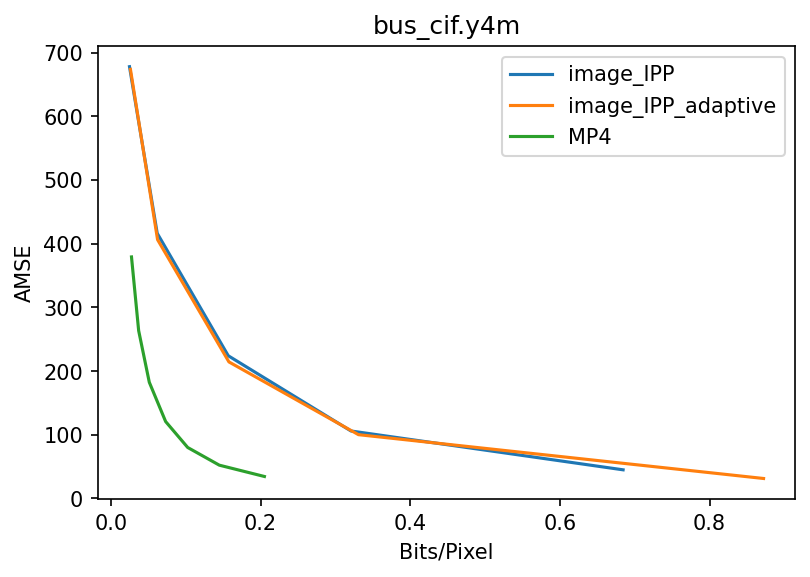

In [45]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_image_IPP), label="image_IPP")
pylab.plot(*zip(*RD_image_IPP_adaptive), label="image_IPP_adaptive")
#pylab.plot(*zip(*RD_image_IPP_QR), label="image_IPP_quantized_residue")
pylab.plot(*zip(*RD_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

## Ignore the rest

## Testing `image_IPP_quantized_residue`

`image_IPP_quantized_residue.py` is a modification of `image_IPP.py` where the prediction-error images are quantized before they are compressed with MP4. Each macro-block is quantized to contribute with the same slope to the reconstructed macro-block. 


### Select `image_IPP_quantized_residue` in `RD_curve.py`

!sed -z -i 's/\nimport image_IPP as codec\n/\n#import image_IPP as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_adaptive as codec\n/\n#import image_IPP_adaptive as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport MP4 as codec\n/\n#import MP4 as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport IPP_compressor as codec\n/\n#import IPP_compressor as codec\n/g' RD_curve.py
!sed -z -i 's/\nimage_IPP_quantized_prediction as codec\n/\n#import image_IPP_quantized_prediction as codec\n/g' RD_curve.py
!sed -z -i 's/\n#import image_IPP_quantized_residue as codec\n/\nimport image_IPP_quantized_residue as codec\n/g' RD_curve.py

In [46]:
!cat -n RD_curve.py | grep "import" 

     5	#import debug
     6	import config
     7	import distortion
     8	import image_3 as frame
    11	    import image_IPP as codec
    13	    import image_IPP_adaptive as codec
    15	    import MP4 as codec
    17	import logging
    18	import logging_config
    28	import argparse


!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [47]:
!cat -n config.py | grep "transform" 

     6	#multiresolution_transform = "DWT"
     7	#multiresolution_transform = "LP"
     8	multiresolution_transform = None


!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [48]:
!cat -n config.py | grep "color" 

    14	color = "YCoCg"
    15	#color = "YCrCb"
    16	#color = "RGB"


In [49]:
# You can see in real-time the output by running "tail -f /tmp/output"
#!python RD_curve.py --first_frame=0 --N_frames=$N_frames 1> >(tee /tmp/output_image_IPP_quantized_residue >&1) | grep BPP | grep Average | cat -n

In [50]:
!grep BPP /tmp/output_image_IPP_quantized_residue | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/image_IPP_quantized_residue.txt

grep: /tmp/output_image_IPP_quantized_residue: No existe el fichero o el directorio


In [51]:
!cat /tmp/image_IPP_quantized_residue.txt

In [52]:
RD_image_IPP_QR = []
with open("/tmp/image_IPP_quantized_residue.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_image_IPP_QR.append((float(rate), float(_distortion)))

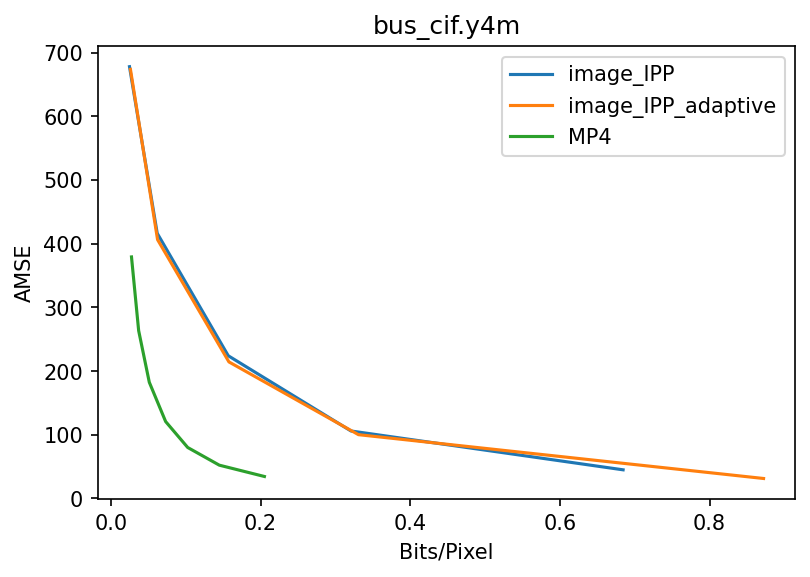

In [53]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_image_IPP), label="image_IPP")
pylab.plot(*zip(*RD_image_IPP_adaptive), label="image_IPP_adaptive")
pylab.plot(*zip(*RD_image_IPP_QR), label="image_IPP_quantized_residue")
pylab.plot(*zip(*RD_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

In [54]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_no_intrablocks), label="No Intra-blocks")
pylab.plot(*zip(*RD_points_with_intrablocks), label="With Intra-blocks")
pylab.plot(*zip(*RD_points_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

NameError: name 'RD_points_no_intrablocks' is not defined

<Figure size 900x600 with 0 Axes>